In [1]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

2024-03-19 18:56:22.555356: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-19 18:56:22.555388: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-19 18:56:22.556564: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-19 18:56:22.563137: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-19 18:56:23.346321: W tensorflow/comp

In [2]:
config = {}
config["num_layers"] = 12
config["hidden_dim"] = 768
config["mlp_dim"] = 3072
config["num_heads"] = 12
config["dropout_rate"] = 0.1
config["num_patches"] = 256
config["patch_size"] = 32
config["num_channels"] = 3

In [3]:
class ClassToken(Layer):
    def __init__(self):
        super().__init__()
    
    def build(self, input_shape):
        w_init = tf.random_normal_initializer()
        self.w = tf.Variable(
            initial_value = w_init(shape=(1, 1, input_shape[-1]), dtype=tf.float32),
            trainable = True
        )

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        hidden_dim = self.w.shape[-1]
        
        cls = tf.broadcast_to(self.w, [batch_size, 1, hidden_dim])
        cls = tf.cast(cls, dtype=inputs.dtype)

        return cls

In [4]:
def mlp (x, cf):
    x = Dense(cf["mlp_dim"], activation="gelu")(x)
    x = Dropout(cf["dropout_rate"])(x)
    x = Dense(cf["hidden_dim"])(x)
    x = Dropout(cf["dropout_rate"])(x)
    return x

def transformer_enconder(x, cf):
    skip_1 = x
    x = LayerNormalization()(x)
    x = MultiHeadAttention(
        num_heads=cf["num_heads"], key_dim=cf["hidden_dim"]
    ) (x, x)

    x = Add()([x, skip_1])

    skip_2 = xx= LayerNormalization()(x)
    x = mlp(x, cf)
    x = Add()([x, skip_2])

    return x


In [5]:
def ViT(cf):
    """ Inputs """
    input_shape = (cf["num_patches"], cf["patch_size"]*cf["patch_size"]*cf["num_channels"])
    inputs = Input(input_shape)

    """ Patch + Position Embeddins """
    patch_embed = Dense(cf["hidden_dim"])(inputs)

    positions = tf.range(start=0, limit=cf["num_patches"], delta=1)
    pos_embed = Embedding(input_dim=cf["num_patches"], output_dim=cf["hidden_dim"])(positions)

    embed = patch_embed + pos_embed

    """ Adding Class Token """
    token = ClassToken()(embed)

    x = Concatenate(axis=1)([token, embed])

    """ Trasnformer Enconder """
    for _ in range(cf["num_layers"]):
        x = transformer_enconder(x, cf)
    
    """ Classification Head """
    x = LayerNormalization()(x)
    x = x[:, 0, :]
    x = Dropout(0.1)(x)
    x = Dense(10, activation="softmax")(x)

    model = Model(inputs, x)
    return model

model = ViT(config)
model.summary()

2024-03-19 18:56:24.361347: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3483 MB memory:  -> device: 0, name: Quadro P2000, pci bus id: 0000:21:00.0, compute capability: 6.1


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 3072)]          0         []                            
                                                                                                  
 dense (Dense)               (None, 256, 768)             2360064   ['input_1[0][0]']             
                                                                                                  
 tf.__operators__.add (TFOp  (None, 256, 768)             0         ['dense[0][0]']               
 Lambda)                                                                                          
                                                                                                  
 class_token (ClassToken)    (None, 1, 768)               768       ['tf.__operators__.add[0][

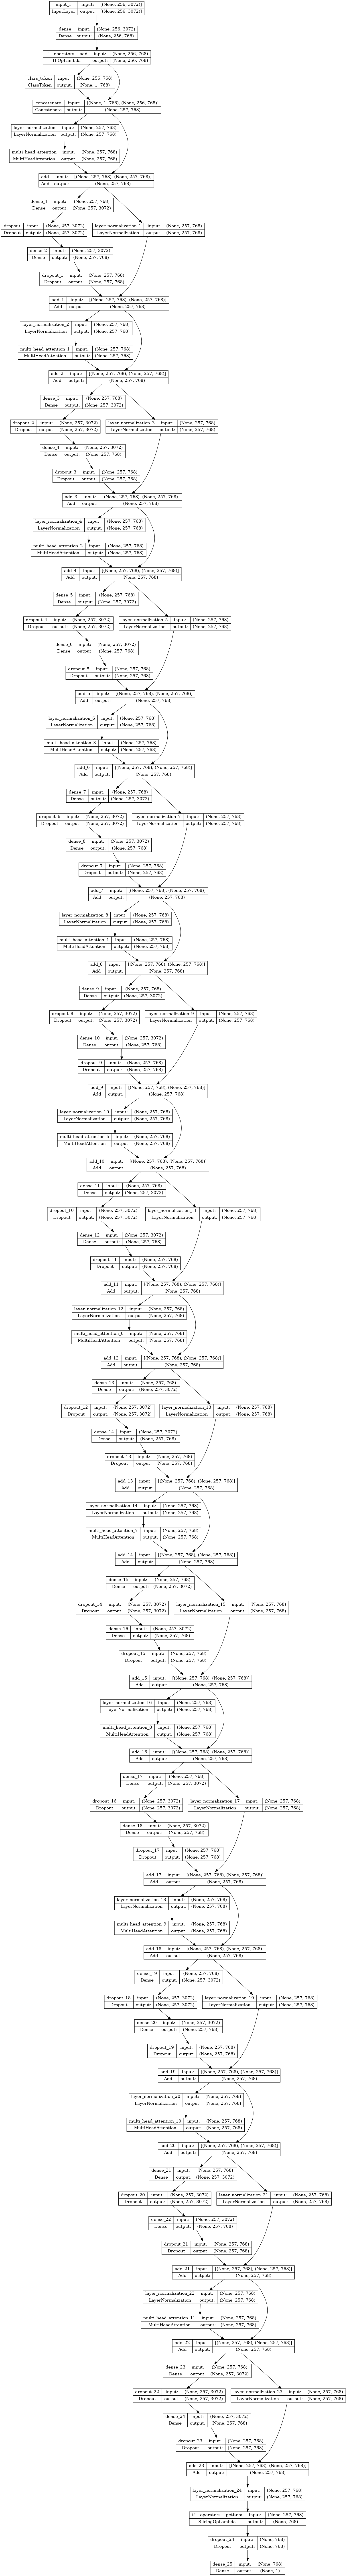

In [6]:
from keras.utils import plot_model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)